In [1]:
import os, tempfile
import logging
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:290: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ionchannelABC-0.2.0-py3.7.egg/ionchannelABC/visualization.py:306: SyntaxWarning: assertion is always true, perhaps remove parentheses?


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.isus_wang import (wang_act_and_kin,
                                   wang_inact)
from experiments.isus_courtemanche import (courtemanche_inact_kin,
                                           courtemanche_deact)

In [5]:
modelfile = 'models/courtemanche_isus.mmt'

## Plot steady-state and tau functions

In [6]:
from ionchannelABC.visualization import plot_variables

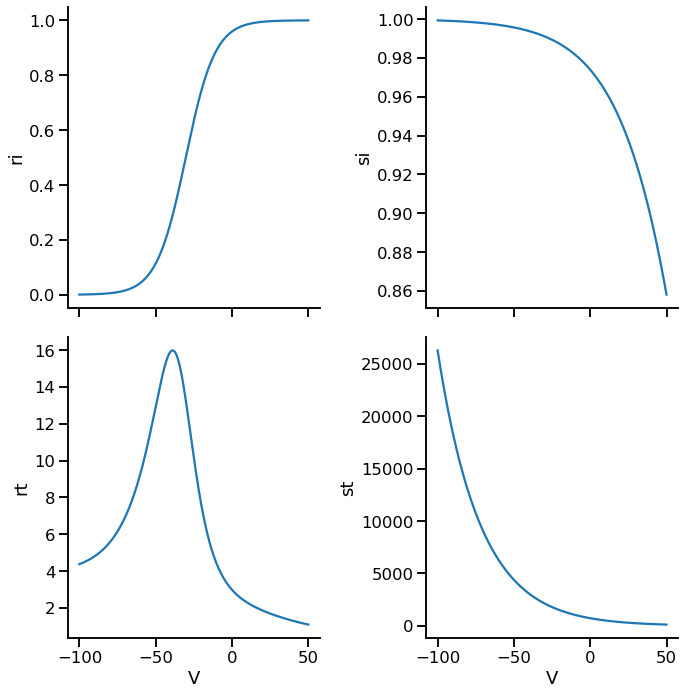

In [7]:
sns.set_context('talk')

V = np.arange(-100, 50, 0.01)

cou_vars = {'ri': 'isus.a_inf',
            'si': 'isus.i_inf',
            'rt': 'isus.tau_a',
            'st': 'isus.tau_i'}

f, ax = plot_variables(V, cou_vars, modelfile, figshape=(2,2))

## a gate -> Activation data only

In [8]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_act_and_kin,
                                                #wang_inact,
                                                courtemanche_deact)
                                                #courtemanche_inact_kin)

In [9]:
assert len(observations)==len(summary_statistics(model({})))

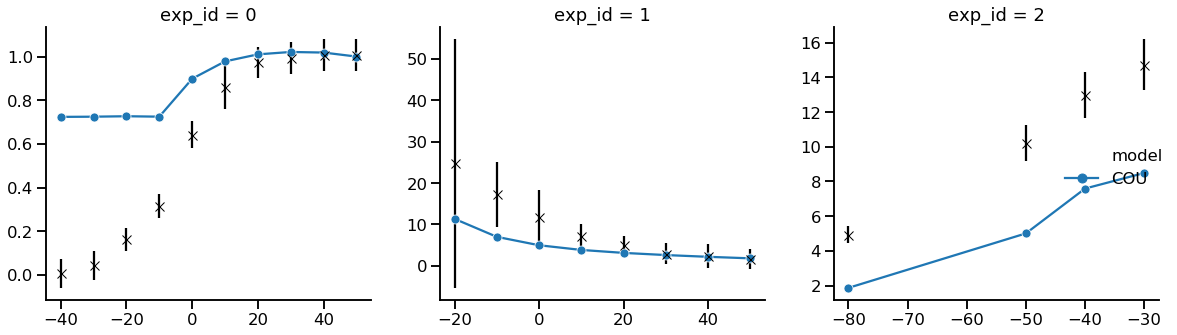

In [10]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                     #wang_inact,
                     courtemanche_deact)
                     #courtemanche_inact_kin)

In [11]:
limits = {'log_isus.r1': (0, 2),
          'isus.r2': (-100, 100),
          'isus.r3': (1e-7, 50),
          
          'isus.p1': (-100, 100),
          'isus.p2': (1e-7, 50),
          'log_isus.p3': (-3, 2),
          'isus.p4': (-100, 100),
          'isus.p5': (1e-7, 50),
          'isus.p6': (-100, 100),
          'isus.p7': (1e-7, 50),
          'log_isus.p8': (-3, 2),
          'isus.p9': (-100, 100),
          'isus.p10': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [12]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_isus_agate_reported.db"))

In [13]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [14]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 8192 particles


In [15]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9291864600781273, '1': 0.9289966364907764, '2': 1.1348736050966737, '3': 1.1351568985577465, '4': 1.0214372272287315, '5': 0.6011154706704985, '6': 0.8515802501165396, '7': 0.8517397519427469, '8': 0.8517397519427501, '9': 0.8515802501165396, '10': 0.06311509727573296, '11': 0.24146268436245014, '12': 0.29232255580339506, '13': 0.6534268894428846, '14': 0.8550117212573514, '15': 0.7403514554934646, '16': 0.6534268894428801, '17': 0.7929901456221022, '18': 3.0675207501965804, '19': 2.2089529135079435, '20': 1.740252220255797, '21': 1.5337603750982902}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [16]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [17]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-30 16:04:18.564083, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [19]:
history = History(db_path)

In [20]:
df, w = history.get_distribution()

In [21]:
df.describe()

name,isus.p1,isus.p10,isus.p2,isus.p4,isus.p5,isus.p6,isus.p7,isus.p9,isus.r2,isus.r3,log_isus.p3,log_isus.p8,log_isus.r1
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,22.253092,40.749613,17.664066,38.553618,18.159890,40.002415,17.068600,31.679564,-0.629053,25.790169,-1.555811,-1.466466,0.993116
std,1.181974,6.327755,2.192803,27.127467,8.666579,27.375713,8.344377,42.900812,54.386336,13.290785,0.446658,0.746972,0.526504
min,18.902317,8.322709,12.047153,-15.046610,0.179113,-14.999768,0.313370,-98.820531,-99.976220,0.040520,-2.991428,-2.999705,0.001895
25%,21.420479,37.246529,16.104045,16.931270,12.597056,17.857836,11.800169,4.017339,-47.798546,15.084338,-1.855165,-2.065849,0.562785
50%,22.274851,41.923930,17.623399,33.718468,16.657489,35.801835,15.872354,38.179307,-0.275114,26.015981,-1.494509,-1.433176,0.988123
75%,23.112827,45.455304,19.094013,57.580917,21.775287,60.396707,20.586777,65.659080,44.440012,36.589031,-1.203510,-0.872068,1.419639
max,25.583921,49.970518,24.534549,99.986409,49.594181,99.944765,48.075433,99.979898,99.932419,49.986673,-0.572106,0.293432,1.999886


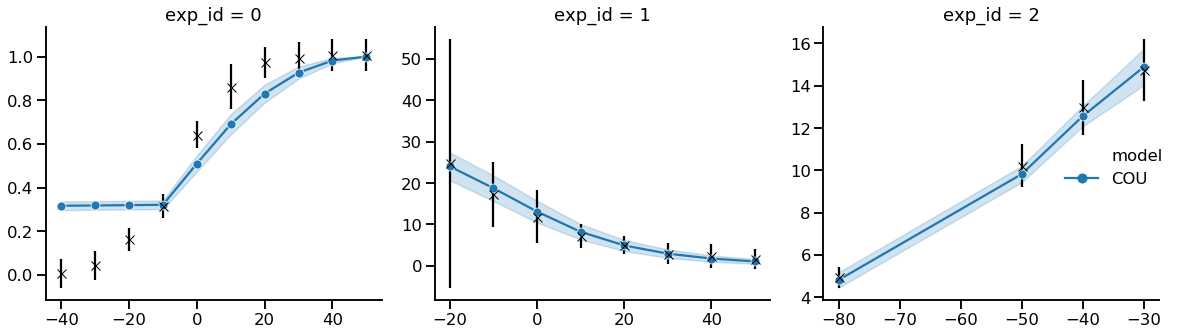

In [22]:
g = plot_sim_results(modelfile,
                     wang_act_and_kin,
                    courtemanche_deact,
                     df=df, w=w)

In [23]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

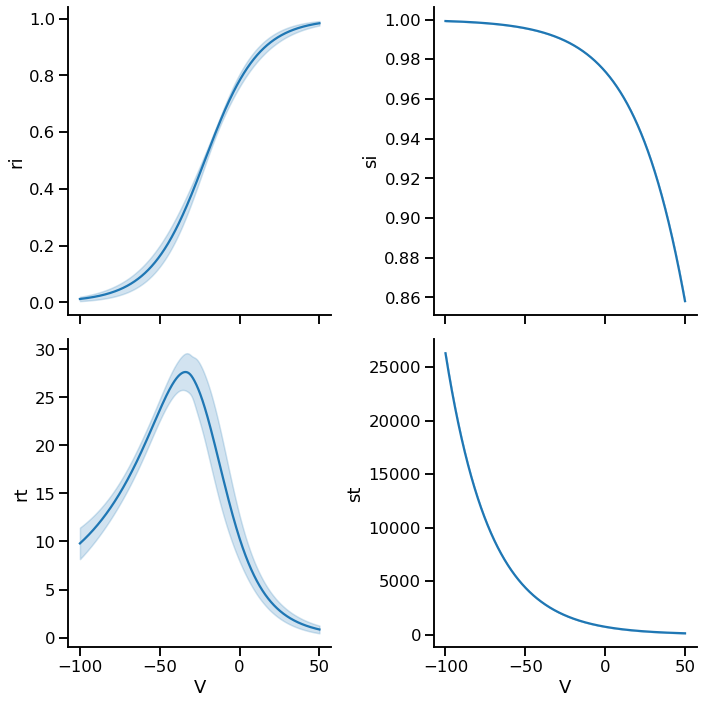

In [24]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_isus.mmt', 
                       [cou_pars],
                       figshape=(2,2))

In [25]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [26]:
m,_,_ = myokit.load(modelfile)

In [27]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

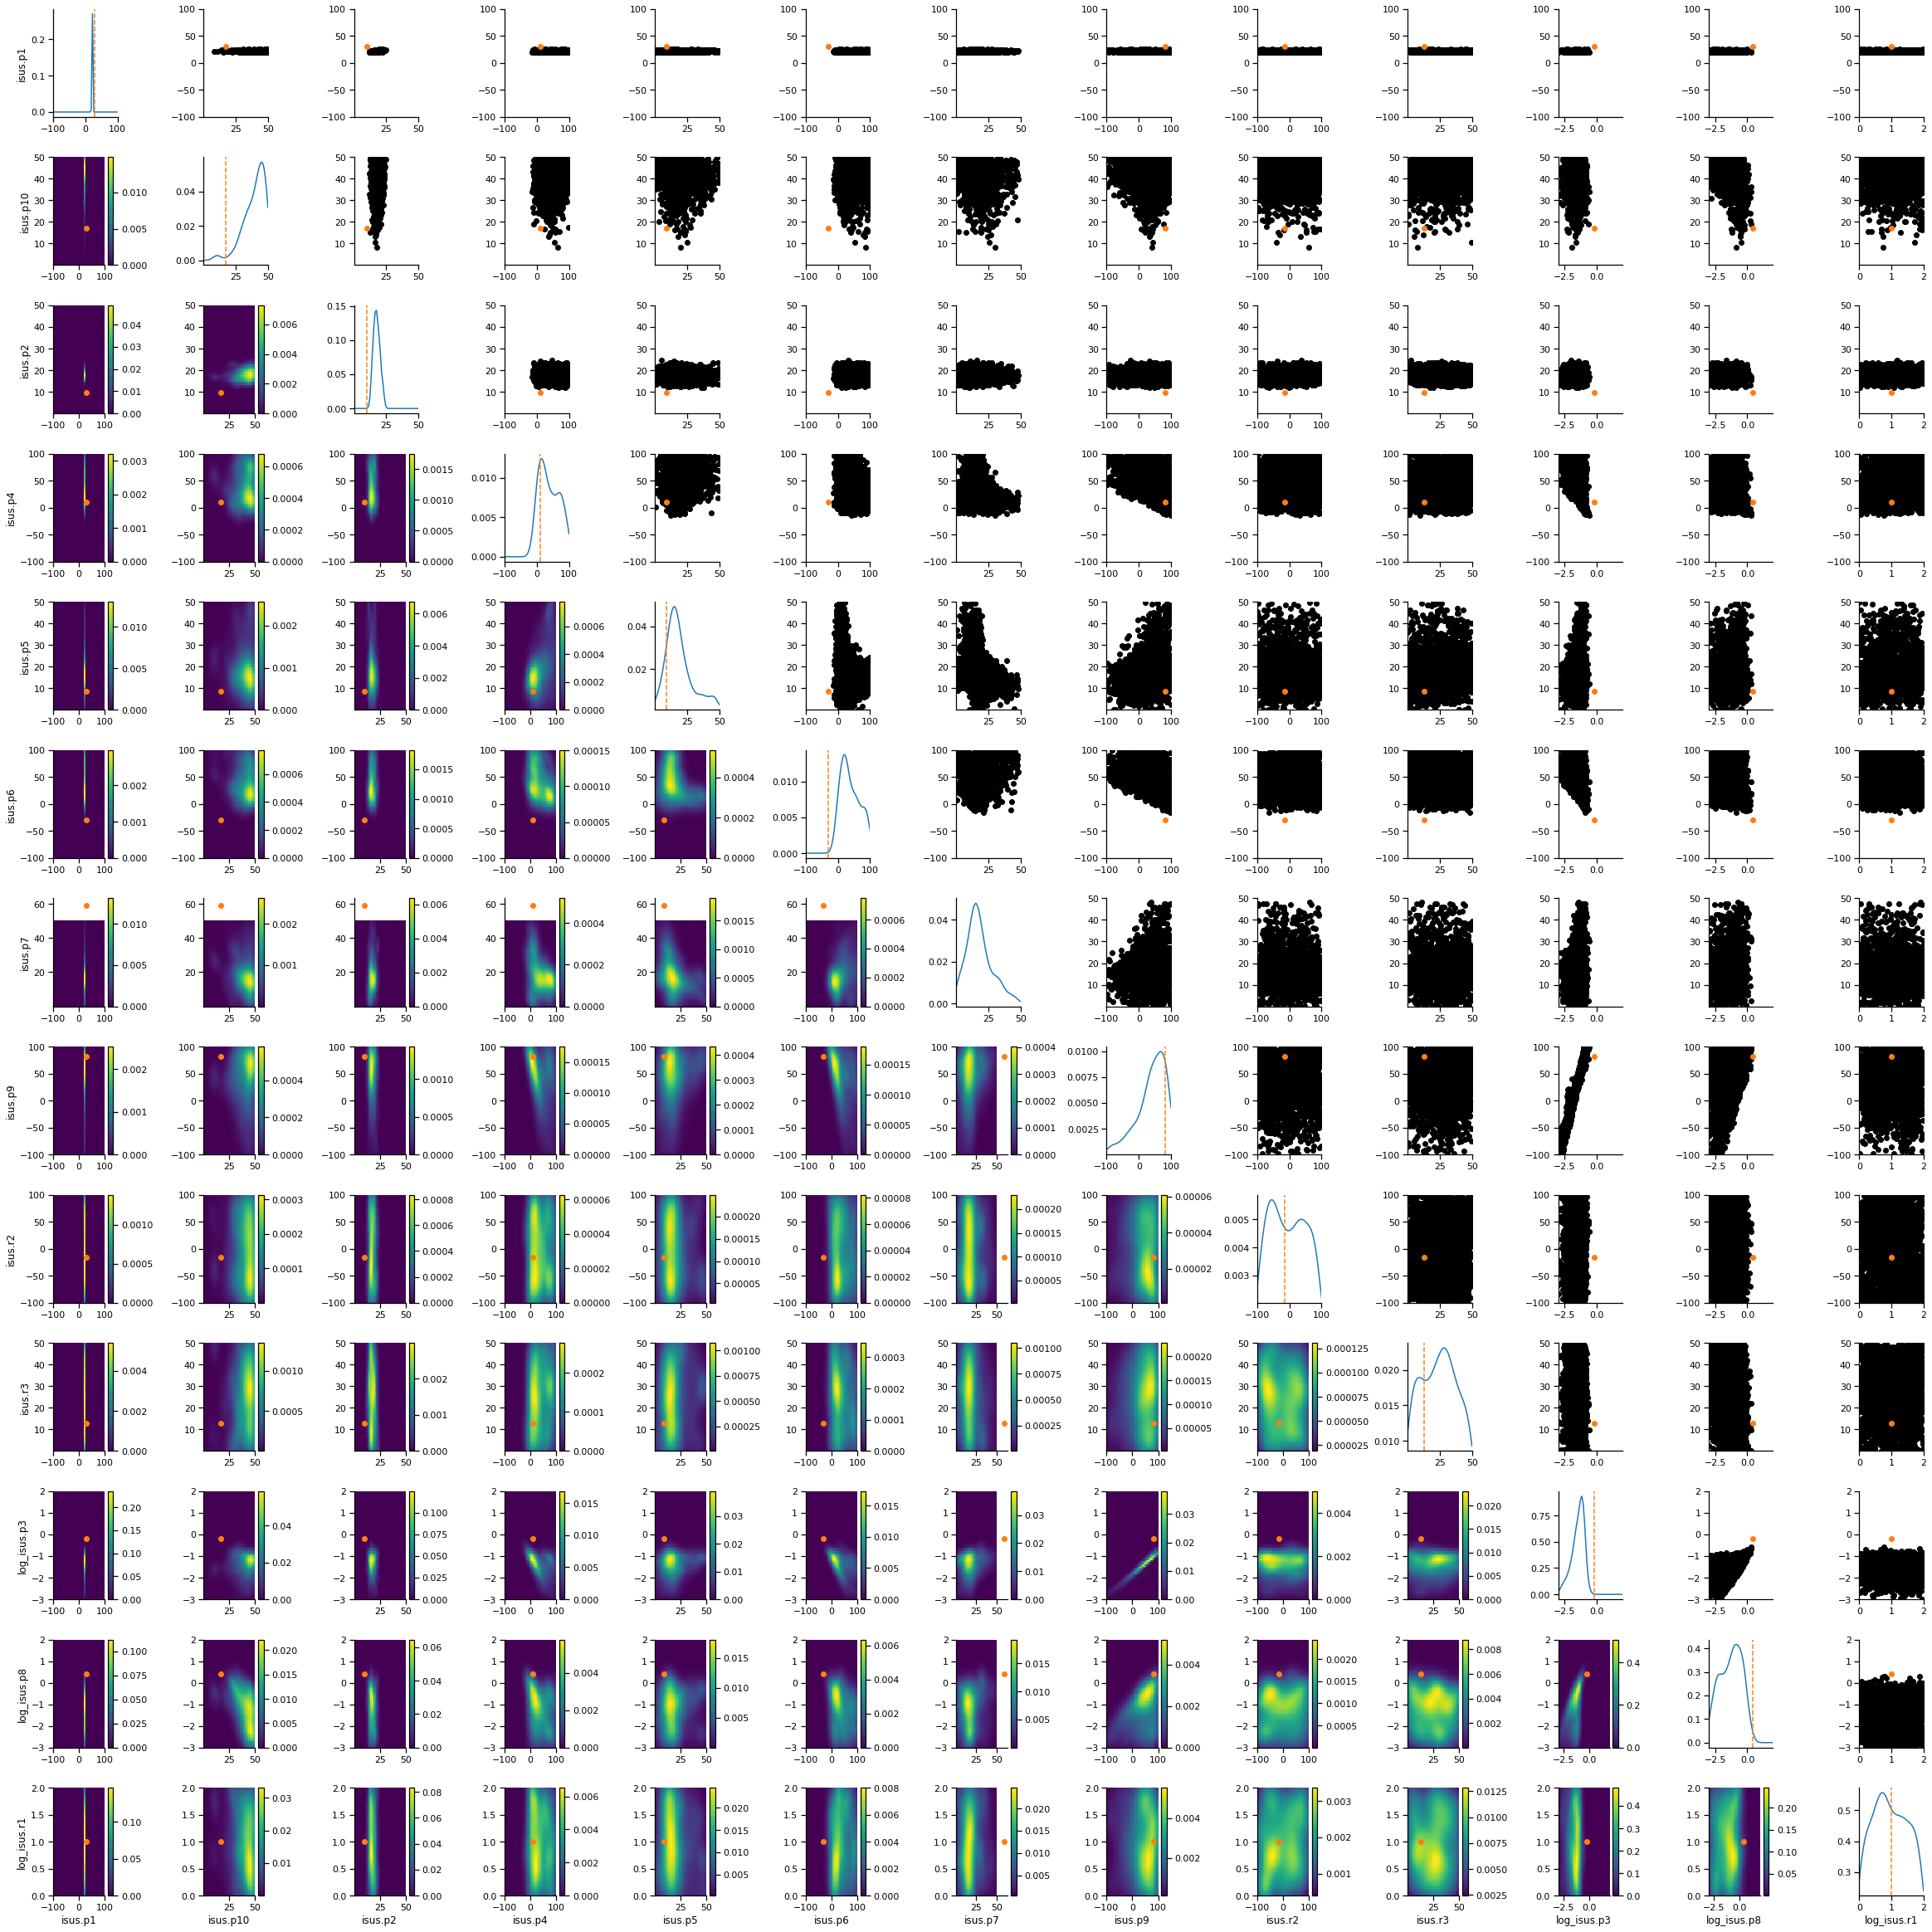

In [28]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

## i gate -> Inactivation data only

In [28]:
observations, model, summary_statistics = setup(modelfile,
                                                wang_inact,
                                                courtemanche_inact_kin)

In [29]:
assert len(observations)==len(summary_statistics(model({})))

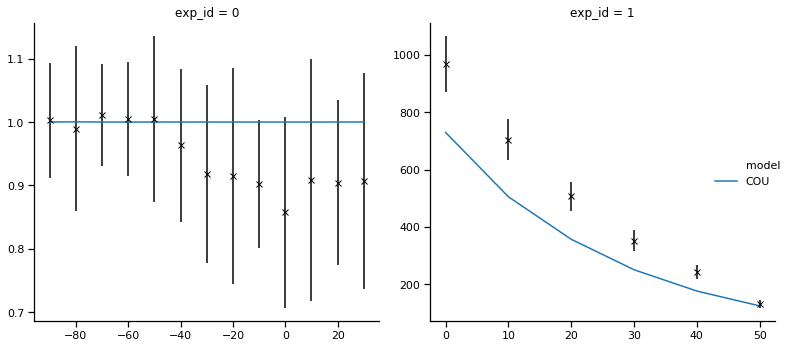

In [30]:
g = plot_sim_results(modelfile,
                     wang_inact,
                    courtemanche_inact_kin)

In [31]:
limits = {'isus.q1': (-200, 0),
          'isus.q2': (1e-7, 50),
          'log_isus.q3': (-1, 4),
          'isus.q4': (-200, 0),
          'isus.q5': (1e-7, 50),
          'isus.q6': (-200, 0),
          'isus.q7': (1e-7, 50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [32]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "courtemanche_isus_igate_reported.db"))

In [33]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 128 particles


In [35]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(1000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.6434389840836746, '1': 0.4454577582117754, '2': 0.7236089400897904, '3': 0.6436444899872479, '4': 0.44545775821177314, '5': 0.4826948259042083, '6': 0.4136393469109322, '7': 0.3407593672894936, '8': 0.5789287268457527, '9': 0.38613736312513286, '10': 0.30478688719752944, '11': 0.4455562454455161, '12': 0.3406441680442984, '13': 1.24504704846522, '14': 1.7106298280289658, '15': 2.3792859713673713, '16': 2.49009409693044, '17': 2.49009409693044, '18': 2.49009409693044}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [36]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [37]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-22 16:03:33.206605, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


### Database results analysis

In [39]:
history = History(db_path)

In [40]:
df, w = history.get_distribution()

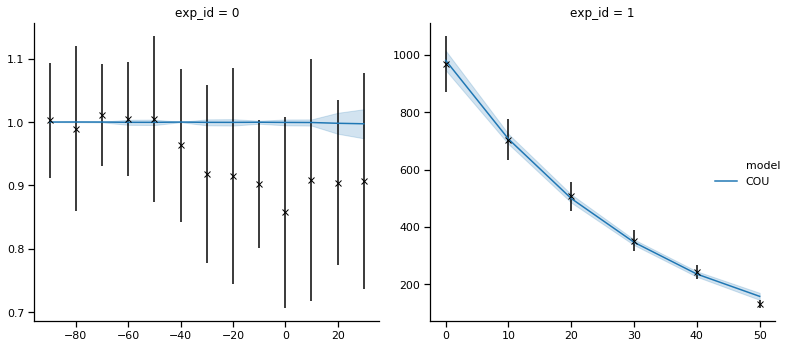

In [41]:
g = plot_sim_results(modelfile,
                     wang_inact,
                    courtemanche_inact_kin,
                     df=df, w=w)

In [42]:
cou_pars = df.sample(n=100, weights=w, replace=True)
cou_pars = cou_pars.set_index([pd.Index(range(100))])
cou_pars = cou_pars.to_dict(orient='records')

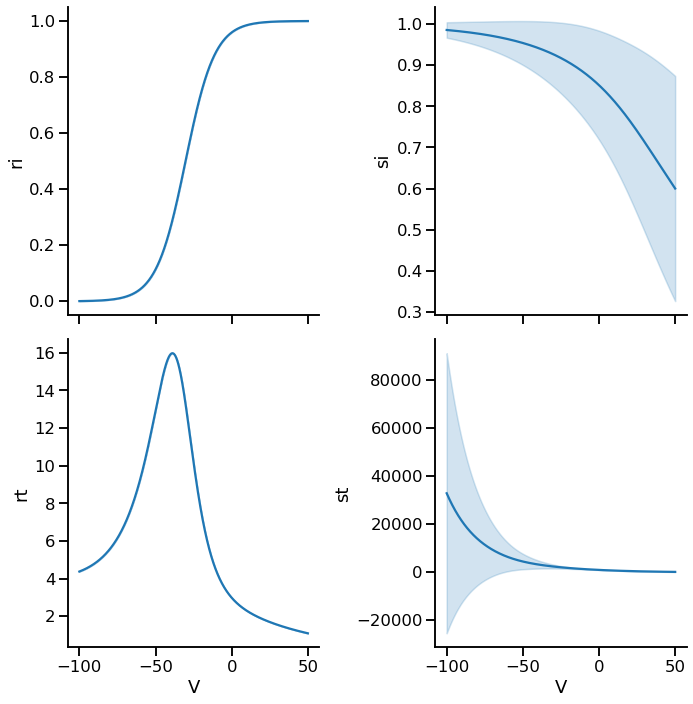

In [44]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, cou_vars, 
                       'models/courtemanche_isus.mmt', 
                       [cou_pars],
                       figshape=(2,2))

In [45]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [46]:
m,_,_ = myokit.load(modelfile)

In [47]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

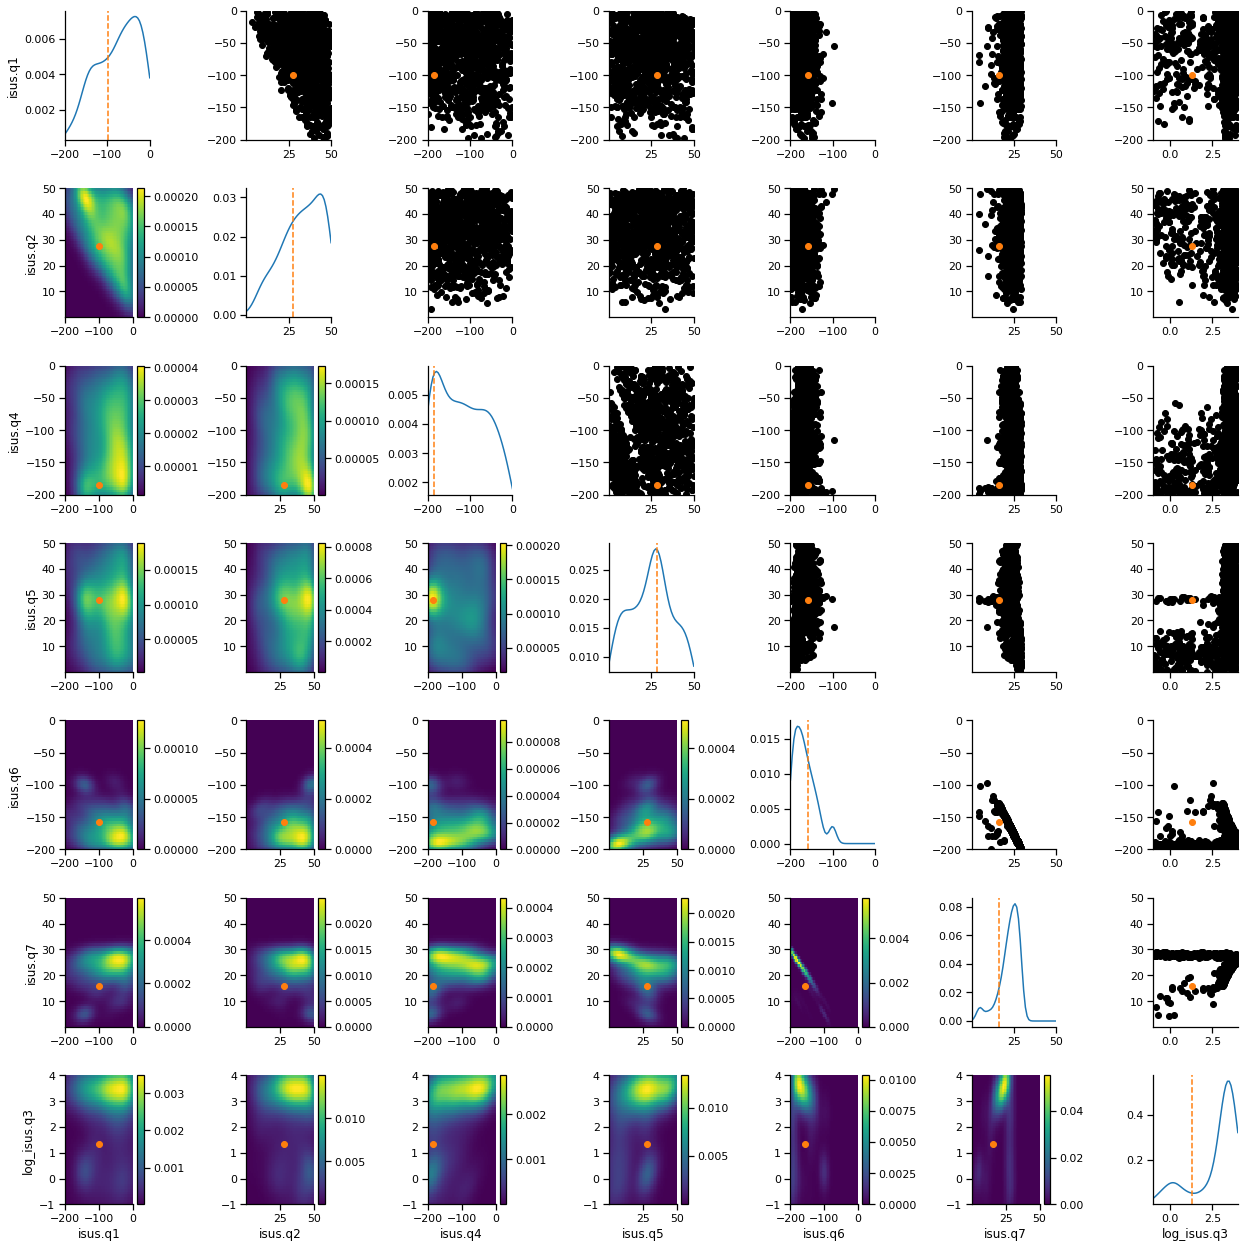

In [48]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)